## Librerías

In [70]:
# Data Wrangling Libraries

import pandas as pd
import numpy as np
import re

# NLP

import nltk
from textblob import TextBlob
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Visualisation Libraries

import seaborn as sns
import networkx as nx
import cufflinks as cf
import plotly.express as px
from ipywidgets import interact
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, IntSlider
import ipywidgets as widgets
import plotly.graph_objects as go

## Datasets

* **"friends_quotes"** dataset de Kaggle https://www.kaggle.com/ryanstonebraker/friends-transcript

* **"Guest_Stars_DF"** dataset creado a partir del friends_quotes dataset y modificado manualmente. Este contiene las líneas que han tenido diferentes actores/actrices invitados/as a la serie duarante la 10 temporadas.

* **"season1_df_modified"** dataset creado a partir del friends_quotes dataset y modificado manualmente. Este contiene las conversaciones por parejas (no contiene las conversaciones grupales), de los 9 personajes que más frases tienen en laprimera temporadas 

* **"script_ross"** dataset creado a partir del friends_quotes dataset y modificado manualmente. Este contiene los diálogos entre Ross y otras personas de la serie en la primera temporada. 

In [71]:
friends = pd.read_csv("friends_quotes.csv")
season_1_main_characters = pd.read_excel("season1_df_modified.xlsx")
guest_stars = pd.read_excel("Guest_Stars_DF.xlsx")


## Data Cleanning

In [72]:
#el episodio 16 no está bien "escrapeado", así que eliminamos las líneas.
friends.drop(friends[(friends["season"] == 1) & (friends["episode_number"] == 16)].index,inplace = True)
# eliminamos las líneas en la columna "author" es "All"
friends.drop(friends[(friends["author"] == "All")].index,inplace = True)

In [73]:
friends["author"] = friends["author"].str.replace("ms. geller","mrs. geller").str.replace("judy","mrs. geller").str.replace("frank jr","frank")

In [74]:
friends["author"] = friends["author"].str.replace("\(([^)]+)\)","").str.lower().str.strip()

In [75]:
chandler =["chan","chandle","chandlers"]
monica =["young monica","fat monica","mnca","monic","monica about to have a heart attack","monica to amy","monica to emma","monica to ross"] 
joey = ["fat joey","joe"]
phoebe = ["phoe","phoeb","phoebe looks down"]
rachel = ["big nosed rachel","rach","rahcel","rache","rachel opens their door","rachel to emma","racel"]
ross = ["ross first has a look of 'huh' then changes it to sarcastic happy","ross looks down","ross makes some sort of sound to let us know it hurt","ross starts playing with a plate","ross starts talking over her 'do you remember' line","ross to monica","ross with a look of wondering how long this is going to go on on his face","young ross","ros"]

In [76]:
def replace_author(i):
    if i in chandler: 
        i = "chandler" 
    elif i in monica:
        i = "monica"
    elif i in joey: 
        i = "joey"
    elif i in phoebe:
        i = "phoebe"
    elif i in rachel: 
        i = "rachel"
    elif i in ross:
        i = "ross"
    else:
        return i

In [77]:
friends["author"] = friends["author"].apply(replace_author).str.capitalize()

## 9 Characters with more lines per season

In [78]:
@interact(Season = IntSlider(min=1, max=10, step=1,value=1))
def more_common_characters(Season):
    more_common_characters = friends[friends.season == Season]["author"].value_counts().head(9).index.to_list()
    sns.set(rc={'figure.figsize':(7,7),'axes.facecolor':'black'}, font_scale=1.5)
    palette = ["red","yellow","#23c6f7"]
    sns.countplot(y='author', data=friends[(friends.author.isin(more_common_characters)) & (friends.season == Season)], order = more_common_characters, palette = palette)
    plt.xlabel("Number of lines")
    plt.ylabel("Character")
    plt.title('9 Characters with more lines per season')
    plt.show()

interactive(children=(IntSlider(value=1, description='Season', max=10, min=1), Output()), _dom_classes=('widge…

## Conversations between the 9 characters with more lines in Season 1

In [79]:
conversation_weights = pd.DataFrame(season_1_main_characters["Conversation"].value_counts(normalize = True)).reset_index()
conversation_weights

,index,Conversation
0,"Ross, Rachel",0.171171
1,"Ross, Carol",0.114114
2,"Chandler, Joey",0.113113
3,"Rachel, Monica",0.086086
4,"Chandler, Phoebe",0.083083
5,"Ross, Joey",0.079079
6,"Susan, Ross",0.065065
7,"Monica, Joey",0.062062
8,"Chandler, Janice",0.054054
9,"Phoebe, Rachel",0.038038


In [80]:
conversation_weights[["A","B"]] = conversation_weights["index"].str.split(",",expand=True)

In [81]:
conversation_weights["A"] = conversation_weights["A"].str.strip()
conversation_weights["B"] = conversation_weights["B"].str.strip()

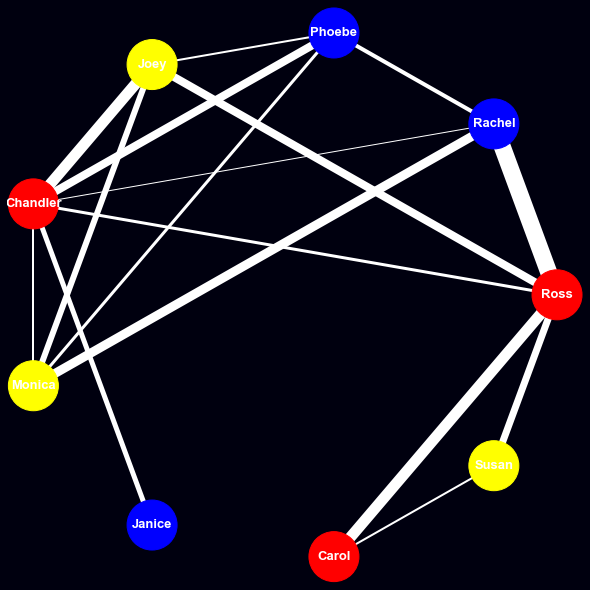

In [82]:
plt.rcParams["figure.figsize"] = (8,8)

G = nx.Graph()
G.add_node("Ross", color='red')
G.add_node("Rachel", color='blue')
G.add_node("Phoebe", color='blue')
G.add_node("Joey", color='yellow')
G.add_node("Chandler", color='red')
G.add_node("Monica", color='yellow')
G.add_node("Janice", color='blue')
G.add_node("Carol", color='red')
G.add_node("Susan", color='yellow')

for i in range(len(conversation_weights)):
    G.add_edge(conversation_weights["A"][i],conversation_weights["B"][i], weight=round(conversation_weights["Conversation"][i]*100))

colors_nodes = nx.get_node_attributes(G,'color').values()
weights = nx.get_edge_attributes(G,'weight').values()
pos = nx.circular_layout(G)

fig = plt.figure()
nx.draw(G, pos, 
        edge_color="white", 
        width=list(weights),
        with_labels=True,
        node_color= colors_nodes, node_size=2500, font_weight='bold', font_color='white', font_size = 13)

fig.set_facecolor("#00000F")

## Guests Stars over the 10 seasons

In [83]:
guest_stars = pd.pivot_table(guest_stars,index=["Actor","season"],
                values = ["quote"],           
               aggfunc='count',fill_value=0)

In [84]:
guest_stars.reset_index(inplace = True)

In [85]:
fig = px.bar(guest_stars, x="season", y="quote", color = "Actor", title="Guest Stars over the 10 Seasons", labels = {"quote": "Number of lines", "season": "Season"})
fig.show()

## Sentiment Analysis

In [86]:
main_characters = ["Ross", "Joey","Chandler","Phoebe","Rachel","Monica"]

In [87]:
friends= friends[friends.author.isin(main_characters)].drop(columns=['episode_number', 'episode_title', "quote_order"]).reset_index(drop = True)

In [88]:
friends["quote"] = friends["quote"].str.replace("\(([^)]+)\)","").str.strip().str.lower().str.split("[.|!|?]", expand = False)

In [89]:
friends = friends.explode("quote")

In [90]:
friends.reset_index(drop = True, inplace = True)

In [91]:
scene = friends[friends["quote"].str.contains("scene:")].index.to_list()

In [92]:
friends = friends.drop(friends.index[scene])

In [93]:
friends["quote"] = friends["quote"].str.replace("[^a-zA-Z' ]","")

In [94]:
friends.reset_index(drop = True, inplace = True)

In [95]:
indexes = []
for i in range(len(friends["quote"])):
    if len(friends["quote"][i]) == 0:
        indexes.append(i)

In [96]:
friends = friends.drop(friends.index[indexes]).reset_index(drop = True)

In [97]:
friends["quote"] = friends["quote"].str.strip()

In [98]:
friends['number_words'] = friends['quote'].str.count(' ') + 1

In [99]:
one_word = friends[friends["number_words"] == 1].index.to_list()

In [100]:
friends = friends.drop(friends.index[one_word]).reset_index(drop = True)

In [101]:
friends["quote"] = friends["quote"].str.replace("'\s","")

In [102]:
friends["quote"] = friends["quote"].str.replace("'cause","because").str.replace("you know","y'know").str.replace("you are","you're").str.replace("come on","c'mon").str.replace("'kay","okay").str.replace("'em","them").str.replace("doin'","doing").str.replace("(ya)","you").str.replace("lemme","let me").str.replace("gonna", "going to").str.replace("'", "")

In [103]:
friends.drop('number_words', axis='columns', inplace=True)

In [104]:
friends.head()

,author,quote,season
0,Monica,theres nothing to tell,1.0
1,Monica,hes just some guy i work with,1.0
2,Joey,cmon youre going out with the guy,1.0
3,Joey,theres gotta be something wrong with him,1.0
4,Chandler,all right joey be nice,1.0


In [105]:
def polarity(x):
    return TextBlob(x).polarity

In [106]:
def sentiment_analysis(x):
    if x > 0.5: 
        x = "Positive"
    elif x < -0.5:
        x = "Negative"
    else:
        x = "Neutral"
    return x
#Less than 0 denotes Negative, I prefer to set < - 0.5
#Equal to 0  denotes Neutral
#Greater than 0 denotes Positive, I prefer to set > 0.5

In [107]:
friends["polarity"] = friends["quote"].apply(polarity).apply(sentiment_analysis)

In [108]:
sentimentanalysis = pd.pivot_table(friends,index=["author"],columns = ["polarity"],
                values = ["quote"],           
               aggfunc='count',fill_value=0)

In [109]:
sentimentanalysis

quote                 
polarity Negative Neutral Positive
author                            
Chandler      242   10508      584
Joey          197   11192      558
Monica        225   10678      524
Phoebe        176   10065      530
Rachel        215   11850      591
Ross          176   11973      569

In [110]:
friends[friends.polarity == "Positive"].head(15)

,author,quote,season,polarity
33,Ross,i hope shell be very happy,1.0,Positive
68,Rachel,this really gorgeous lamauge gravy boat,1.0,Positive
112,Monica,okay look this is probably for the best yknow,1.0,Positive
134,Ross,thatd be good,1.0,Positive
149,Phoebe,that cant be good,1.0,Positive
173,Chandler,its a beautiful thing,1.0,Positive
185,Joey,she got the furniture the stereo the good tv w...,1.0,Positive
224,Joey,this is the best thing that ever happened to you,1.0,Positive
228,Ross,i honestly dont know if im hungry or horny,1.0,Positive
240,Rachel,but joanne loved chachi,1.0,Positive


#### By words

#### Code

In [111]:
vectorizer = CountVectorizer(min_df = 0.0002, ngram_range =(1,1))
matrix = vectorizer.fit_transform(friends["quote"])
matrix

<70853x1775 sparse matrix of type '<class 'numpy.int64'>'
	with 411165 stored elements in Compressed Sparse Row format>

In [112]:
matrix.shape

(70853, 1775)

In [113]:
y = friends.iloc[:, 0].values

In [114]:
counts = pd.DataFrame(matrix.toarray(),index = list(y),
                      columns=vectorizer.get_feature_names())

In [115]:
counts = counts.groupby(counts.index).sum()

In [116]:
counts.T.columns

Index(['Chandler', 'Joey', 'Monica', 'Phoebe', 'Rachel', 'Ross'], dtype='object')

In [117]:
most_spoken_words = counts.T.reset_index()
most_spoken_words

,index,Chandler,Joey,Monica,Phoebe,Rachel,Ross
0,able,11,9,9,8,11,16
1,about,339,406,379,319,379,398
2,absolutely,4,4,9,6,15,8
3,accent,2,5,4,2,1,5
4,accept,5,0,4,2,3,7
...,...,...,...,...,...,...,...
1770,yours,16,13,14,13,12,12
1771,yourself,20,16,28,26,20,20
1772,youve,40,34,40,37,47,45
1773,youyou,12,18,18,3,16,37


In [118]:
stop_words = stopwords.words('english')

In [119]:
most_spoken_words["sentiment"] = most_spoken_words["index"].apply(polarity).apply(sentiment_analysis)

In [120]:
most_spoken_words.drop(most_spoken_words[most_spoken_words["index"].isin(stop_words)].index,inplace = True)

In [121]:
most_spoken_words.drop(most_spoken_words[most_spoken_words["sentiment"]=="Neutral"].index,inplace = True)

In [122]:
most_spoken_words.set_index(['index','sentiment'], inplace = True)

#### Plot

In [129]:
@interact(actor =list(most_spoken_words.columns))
def sentiment(actor):
    x = pd.DataFrame(most_spoken_words.loc[:,actor]).reset_index()
    positive = x[x.sentiment == "Positive"].sort_values(by = actor, ascending = False).head(10)
    negative = x[x.sentiment == "Negative"].sort_values(by = actor, ascending = False).head(10)
    negative[actor] = negative[actor] * -1
    sa_ch = pd.concat([positive,negative])
    gfg = sa_ch.pivot_table(sa_ch,index='index', columns='sentiment', fill_value = 0)
    gfg.columns = gfg.columns.droplevel(0)
    gfg = gfg.sort_values(['Positive','Negative'], ascending = True)
    
    Diverging = go.Figure()
    Diverging.add_trace(go.Bar(x=gfg["Negative"],
                               y=gfg.index,
                               orientation='h',
                               name="Negative",
                               hovertemplate="%{y}: %{x}"))

    Diverging.add_trace(go.Bar(x=gfg["Positive"],
                               y=gfg.index,
                               orientation='h',
                               name="Positive",
                               hovertemplate="%{y}: %{x}"))

    Diverging.update_layout(title_text= f"{actor}'s Sentiment Analysis")
    Diverging.show()

interactive(children=(Dropdown(description='actor', options=('Chandler', 'Joey', 'Monica', 'Phoebe', 'Rachel',…

## TfidfVectorizer (most spoken words)

In [230]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 0.0002, ngram_range =(3,3))

In [231]:
X = tfidf.fit_transform(friends["quote"])
y = friends.iloc[:, 0].values

In [232]:
counts2 = pd.DataFrame(X.toarray(),index = list(y),
                      columns=tfidf.get_feature_names())
counts2 = counts2.groupby(counts2.index).sum()

In [233]:
counts2.T["Joey"].sort_values(ascending = False).head(15)

im going to       57.323209
oh my god         53.800666
going to be       51.584386
what are you      36.522808
check it out      31.715833
youre going to    30.864538
no no no          27.156222
what do you       26.370328
do you think      24.755160
going to do       23.239721
dont want to      23.069648
are you doing     21.500855
not going to      21.250064
want you to       18.617322
days of our       18.579052
Name: Joey, dtype: float64

In [234]:
from pyvis.network import Network

In [235]:
net = Network(notebook = True)

In [236]:
g = Network(notebook = True, bgcolor= "black", font_color='white', height='700px', width='100%')
g.add_node("Ross", color='red', size=50, shape = "circle")
g.add_node("Rachel", color='blue', size=50, shape = "circle")
g.add_node("Chandler", color='yellow', size=50, shape = "circle")
g.add_node("Phoebe", color='red', size=50, shape = "circle")
g.add_node("Joey", color='blue', size=50, shape = "circle")
g.add_node("Monica", color='yellow', size=50, shape = "circle")
g.add_node("Janice", color='green', size=50, shape = "circle")
g.add_node("Carol", color='green', size=50, shape = "circle")
g.add_node("Susan", color='green', size=50, shape = "circle")

for i in range(len(conversation_weights)):
    g.add_edge(conversation_weights["A"][i],conversation_weights["B"][i], value=round(conversation_weights["Conversation"][i]*100),color="white", length = 400)


In [237]:
g.show("friends.html")